In [9]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.optimizers import Adam

Constant

In [10]:
# days to refer to train
WINDOW_SIZE = 30

In [11]:
features = ['aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

Data Split

In [12]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 7 + 1):  # predict 7 days
        X.append(data[i:i+window_size])         
        y.append(data[i+window_size:i+window_size+7]) 
    return np.array(X), np.array(y)

Define Model

In [ ]:
model = Sequential()
model.add(GRU(64, activation='tanh', return_sequences=True, input_shape=(WINDOW_SIZE, len(features))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(GRU(32, activation='tanh', return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(7 * len(features)))
model.add(Reshape((7, len(features))))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

In [16]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

Baseline model learned 3 years of data in busan

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tscv = TimeSeriesSplit(n_splits=5)

busan_df = pd.read_csv('./pollution_data/baseline_data/Busan_pollution_data_3_years.csv')
busan_df = busan_df[features]
data_array = busan_df.to_numpy()

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_array)

X, y = create_sequences(data_scaled, WINDOW_SIZE)

histories = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(f"Train shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Test shape: X={X_test.shape}, y={y_test.shape}")

    histories.append(model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20,
              batch_size=32, callbacks=[early_stopping]))


Train shape: X=(4360, 30, 9), y=(4360, 7, 9)
Test shape: X=(4355, 30, 9), y=(4355, 7, 9)
Epoch 1/20


TypeError: 'NoneType' object is not callable

In [9]:
model.save('./models/mj_pretrained_baseline_model_GRU_capable.keras')
model.save('./models/mj_pretrained_baseline_model_GRU_capable.h5')


c:\Users\minja\anaconda3\envs\tfjs_convert\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


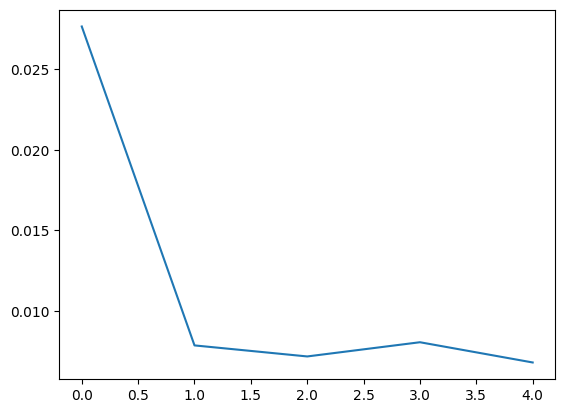

In [29]:
losses = []
for history in histories:
    losses.append(history.history['val_loss'][0])
plt.plot(losses)

원래의 scale로 바꾸기 위하여 받아온 데이터의 평균을 이 값에 곱해서 사용하면 될듯

1/1 [==============================] - 0s 16ms/step


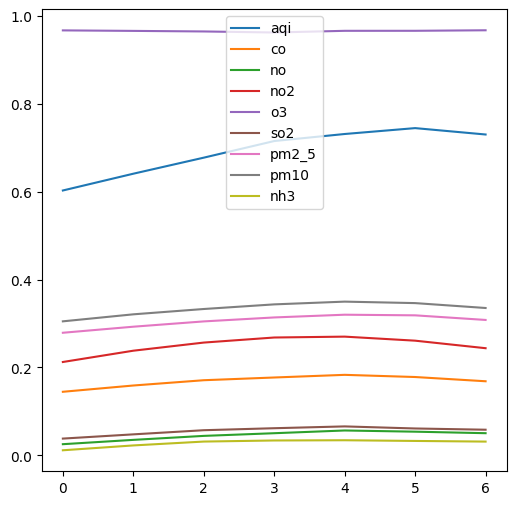

In [26]:
plt.figure(figsize=(6,6))
plt.plot(model.predict(X[4390:4420])[-1])
plt.legend(features, loc='best')

Fine tuning with other cities's dataset for 1 year

In [11]:
from glob import glob

datasets = glob('./pollution_data/*.csv')

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for dataset in datasets:
    print(f'Dataset: {dataset[17:]}')
    df = pd.read_csv(dataset)
    df = df[features]
    data_array = df.to_numpy()
    scaler = MinMaxScaler()
    tscv = TimeSeriesSplit(n_splits=5)

    data_scaled = scaler.fit_transform(data_array)

    X, y = create_sequences(data_scaled, WINDOW_SIZE)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train, validation_data=(X_test, y_test),
                  epochs=20, batch_size=32, callbacks=[early_stopping])


Dataset: California_pollution_data.csv
Epoch 1/20
47/47 [==============================] - 1s 28ms/step - loss: 0.0119 - mae: 0.0708 - val_loss: 0.0102 - val_mae: 0.0671
Epoch 2/20
47/47 [==============================] - 1s 26ms/step - loss: 0.0088 - mae: 0.0603 - val_loss: 0.0083 - val_mae: 0.0588
Epoch 3/20
47/47 [==============================] - 1s 24ms/step - loss: 0.0082 - mae: 0.0583 - val_loss: 0.0076 - val_mae: 0.0538
Epoch 4/20
47/47 [==============================] - 1s 25ms/step - loss: 0.0076 - mae: 0.0560 - val_loss: 0.0078 - val_mae: 0.0544
Epoch 5/20
47/47 [==============================] - 1s 27ms/step - loss: 0.0073 - mae: 0.0549 - val_loss: 0.0113 - val_mae: 0.0711
Epoch 6/20
47/47 [==============================] - 1s 25ms/step - loss: 0.0072 - mae: 0.0546 - val_loss: 0.0081 - val_mae: 0.0567
Epoch 7/20
47/47 [==============================] - 1s 25ms/step - loss: 0.0070 - mae: 0.0538 - val_loss: 0.0075 - val_mae: 0.0539
Epoch 8/20
47/47 [==========================

In [13]:
model.save('./models/mj_fine_tuned_gru_model_capable.keras')
model.save('./models/mj_fine_tuned_gru_model_capable.h5')

c:\Users\minja\anaconda3\envs\tfjs_convert\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
new_model = tf.keras.models.load_model('./models/mj_fine_tuned_gru_model_capable.keras')

In [15]:
!tensorflowjs_converter --input_format keras ./models/mj_fine_tuned_gru_model.keras ./model/mj_fine_tuned_gru_model_tfjs


Traceback (most recent call last):
  File "C:\Users\minja\anaconda3\envs\tfjs_convert\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\minja\anaconda3\envs\tfjs_convert\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\minja\anaconda3\envs\tfjs_convert\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\minja\anaconda3\envs\tfjs_convert\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\minja\anaconda3\envs\tfjs_convert\lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\minja\anaconda3\envs\tfjs_convert\lib\site-packages\tensorflowjs\converters\converter.py", line 38, in <module>
    from tensorflowjs.converters import tf_saved_model_conversion_v2
  File "C:\Users\minja\anaconda3\envs\tfj

In [16]:
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model

# 모델 변환
model = load_model('model.h5')
tfjs.converters.save_keras_model(model, 'tfjs_model')


NotFoundError: c:\Users\minja\anaconda3\envs\tfjs_convert\lib\site-packages\tensorflow_decision_forests\tensorflow\ops\inference\inference.so not found